### The Goal:
The goal of this project is to write a python function with the following inputs and outputs:

#### Input: 
A quantum circuit containing a diagonal unitary operator $U$, such that $U \Ket{x}_n = e^{2\pi\Theta(x)}\Ket{x}_n$, such that all values of $e^{2\pi\Theta(x)}$ are distinct, a number $d$, such that $2^d \Theta(x) \in \mathbb{Z}$ for each $x$, and a value $t \in [0,1]$ with the promise that there exists only one $x$ such that $e^{2 \pi i t}=e^{2 \pi i \Theta(x)}$. 

#### Output: 
Output $x$. 

In [49]:
## Import necessary libraries
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
import numpy as np
from qiskit.circuit.library import MCXGate
from qiskit.circuit.library import ZGate

In [50]:
## Function to create diagonal unitary 
# Input: A array of length N=2^n entries
from qiskit.circuit.library import Diagonal

def diagonal_unitary_from_array(n, diag_entries,k):
    """
    Create a diagonal unitary matrix from an array of complex entries.

    Parameters:
        n (int): Number of qubits (must satisfy len(diag_entries) == 2^n)
        diag_entries (array-like): Length-2^n complex array specifying diagonal unitary entries

    Returns:
        QuantumCircuit: A circuit implementing the controlled diagonal unitary operator CU^(2^k)
    """
    diag_entries = np.asarray(diag_entries, dtype=complex)
    N = 2 ** n

    if diag_entries.shape[0] != N:
        raise ValueError(f"Length of input array must be 2^{n} = {N}.")

    # Check unitarity: All entries must have modulus 1
    if not np.allclose(np.abs(diag_entries), 1, atol=1e-10):
        raise ValueError("All entries must have magnitude 1 to form a unitary diagonal matrix.")

    # Create the diagonal gate
    diag_gate = Diagonal([l**(2**k) for l in diag_entries])
    controlled_diag_gate = diag_gate.control(1)

    # Wrap in a quantum circuit
    qc = QuantumCircuit(n)
    qc.append(diag_gate, qc.qubits)

    return controlled_diag_gate

### Part 1: Preliminaries.

We start with implementing the preliminaries. This includes the quantum fourier transform and inverse quantum fourier transform, as well as a quantum phase estimator. 

In [51]:
### Implement QFT and inverse QFT
def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p)

    return QFT_circuit

def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit

Next, we implement a quantum phase estimator. It takes as input a quantum state $\Ket{\Psi}$, an operator $U$ such that $U \Ket{\Psi}=e^{2 \pi i \Theta} \Ket{\Psi}$, and $d \in \mathbb{IN}$, and outputs $\lfloor 2^d \Theta \rfloor$. To start with, we design a function that takes as input a circuit for the controlled $U$ operation for an arbitrary unitary operator $U$ and an integer $k$, and outputs a circuit that implements the circuit $CU^{2^k}$. The simplest way of doing so requires applying the $CU$ operator in sequence $2^k$ times, this circuit has depth $2^k$ however. 

In [52]:
def controlled_U_power(CU,k,n):
    psi = QuantumRegister(size=n, name="Psi")
    control=QuantumRegister(size=1, name="control")
    circuit=QuantumCircuit(control, psi)
    for j in range(2**k):
        circuit.compose(CU, qubits=control[:]+ psi[:], inplace=True)
    return circuit


In [53]:
def quantum_phase_estimator(d,n,diag_entries):
    ## Input: A quantum circuit representing an n qubit operator U, and d, 0. 
    ## Output $\lfloor 2^d \Theta \rfloor$

    theta = QuantumRegister(size=d, name="Theta")
    psi = QuantumRegister(size=n, name="Psi")
    circuit=QuantumCircuit(theta, psi)
    for j in range(d):
        circuit.h(theta[j])
        gate=diagonal_unitary_from_array(n, diag_entries,j)
        circuit.append(gate, [theta[j], *psi])
    # append an IQFT circuit:
    circuit.compose(inverse_quantum_fourier_transform(d), qubits=theta, inplace=True)
    return circuit

### Part 2: Marker for Grover's algorithm. 

Having implemented the preliminaries, we implement an circuit $M$, given the unitary operator $U$, such that:

$$M \Ket{x}_n \Ket{t}_d =\begin{cases} -\Ket{x}_n \Ket{t}_d \text{ if } U \Ket{x}_n=e^{\frac{2 \pi i t}{2^d}} \Ket{x} \\ \Ket{x}_n \Ket{t}_d \text{ otherwise}   \end{cases}$$

This is a Marker oracle which we use for Grover's search. Importantly, we need to make sure that the marker resets all ancillas back to zero, because we will need to repeatedly apply this oracle in Grover search. 

In [54]:
def Marker(d,n,diag_entries):
    x=QuantumRegister(size=n, name = "x")
    t=QuantumRegister(size=d, name="t")
    phase=AncillaRegister(size=d, name="phase")
    z=AncillaRegister(size=1, name="control")
    circuit=QuantumCircuit(x,t,phase,z)
    QPE=quantum_phase_estimator(d,n,diag_entries)
    # We start with copying the phase of U when acting on x on the ancilla qubits.
    circuit.compose(QPE, qubits=[*phase, *x], inplace=True)
    #The next step: the ancilla register phase[i] is set to 1 if phase[i]=t[i] and 0 otherwise:
    #Start with replacing phase[i] with phase[i] + t[i] mod 2
    for i in range(d):
        circuit.cx(t[i], phase[i])
    #flip each gate in phase:
    circuit.x(phase)
    # Multicontrolled x gate on z, with phase as controls:
    mcx = MCXGate(num_ctrl_qubits=d)
    circuit.append(mcx, qargs=[*phase, z])
    
    # Finally: add a phase of (-1) if z is 1, and nothing otherwise:
    circuit.p(np.pi, z) 

    #reset the ancilla registers to 0. step 1: Uncompute the MCX gate
    mcx = MCXGate(num_ctrl_qubits=d)
    circuit.append(mcx, qargs=[*phase, z])
    
    #resetting step 2: reset the x gates on phase
    circuit.x(phase)
    
    #resetting step 3: reset the cx gates on phase
    for i in range(d):
        circuit.cx(t[i], phase[i])
    #reset step 4: uncompute QPE algorithm. 
    circuit.compose(QPE.inverse(), qubits=[*phase, *x], inplace=True)
    return circuit 

### Part 3: Grover Search.

We implement a circuit for Grover search, with the above designed marker circuit as a marking subcircuit. 

In [55]:
def grover(d,n, diag_entries):
    #takes as input n and a marker circuit, performs grover search on it

    #define the number of rounds:
    T=int(np.round(np.pi/(4*np.arcsin(1/np.sqrt(2**n)))-0.5))
    x=QuantumRegister(size=n, name = "x")
    t=QuantumRegister(size=d, name="t")
    phase=AncillaRegister(size=d, name="phase")
    z=AncillaRegister(size=1, name="control")
    grover=QuantumCircuit(x,t,phase,z)
    #create a marker circuit, and extract the marker registers
    Mark=Marker(d,n,diag_entries)

    #We put the x registers in a uniform superposition
    grover.h(x)
    
    #perform the grover iteration T times:
    for j in range(T):
        grover.barrier()
        grover.compose(Mark, inplace=True)
        grover.h(x)
        grover.x(x)
        #mcz = ZGate().control(n-1)
        #x[0:n-1] + [x[n-1]]
        #grover.append(mcz, qargs=[*x])

        grover.h(x[n-1])  # Convert Z to X via basis change
        grover.append(MCXGate(n - 1), x[0:n-1] + [x[n-1]])  # MCX flips target if all controls are 1
        grover.h(x[n-1])
        
        grover.x(x)
        grover.h(x)
    return grover
        

### Part 4: Putting it all together and benchmarking.

We start creating $2^n$ random numbers in $\{0,1,\dots, 2^{d}-1\}$. 

In [58]:
n=3
d=3
#Create 2^n random diagonal entries of bit complexity d. 
N = 2**n
D = 2**d

if N > D:
    raise ValueError("Cannot generate unique random integers: 2^n > 2^d")

# Create an array with the i-th diagonal entry bein
random_array=np.random.choice(D, size=N, replace=False)
print(random_array)



[1 4 2 3 6 0 7 5]


Now, we suppose we want to find the eigenvector corresponding to the phase $6$. We would need the circuit to find the eigenvector $\Ket{4}$. To do so, we run the circuit on the inputs $\Ket{0} \Ket{6} \Ket{0} \Ket{0}$, and output the final statevector. 

Now, we need to test the Grover circuit on this input. To start with, we draw the grover circuit with this as input. 

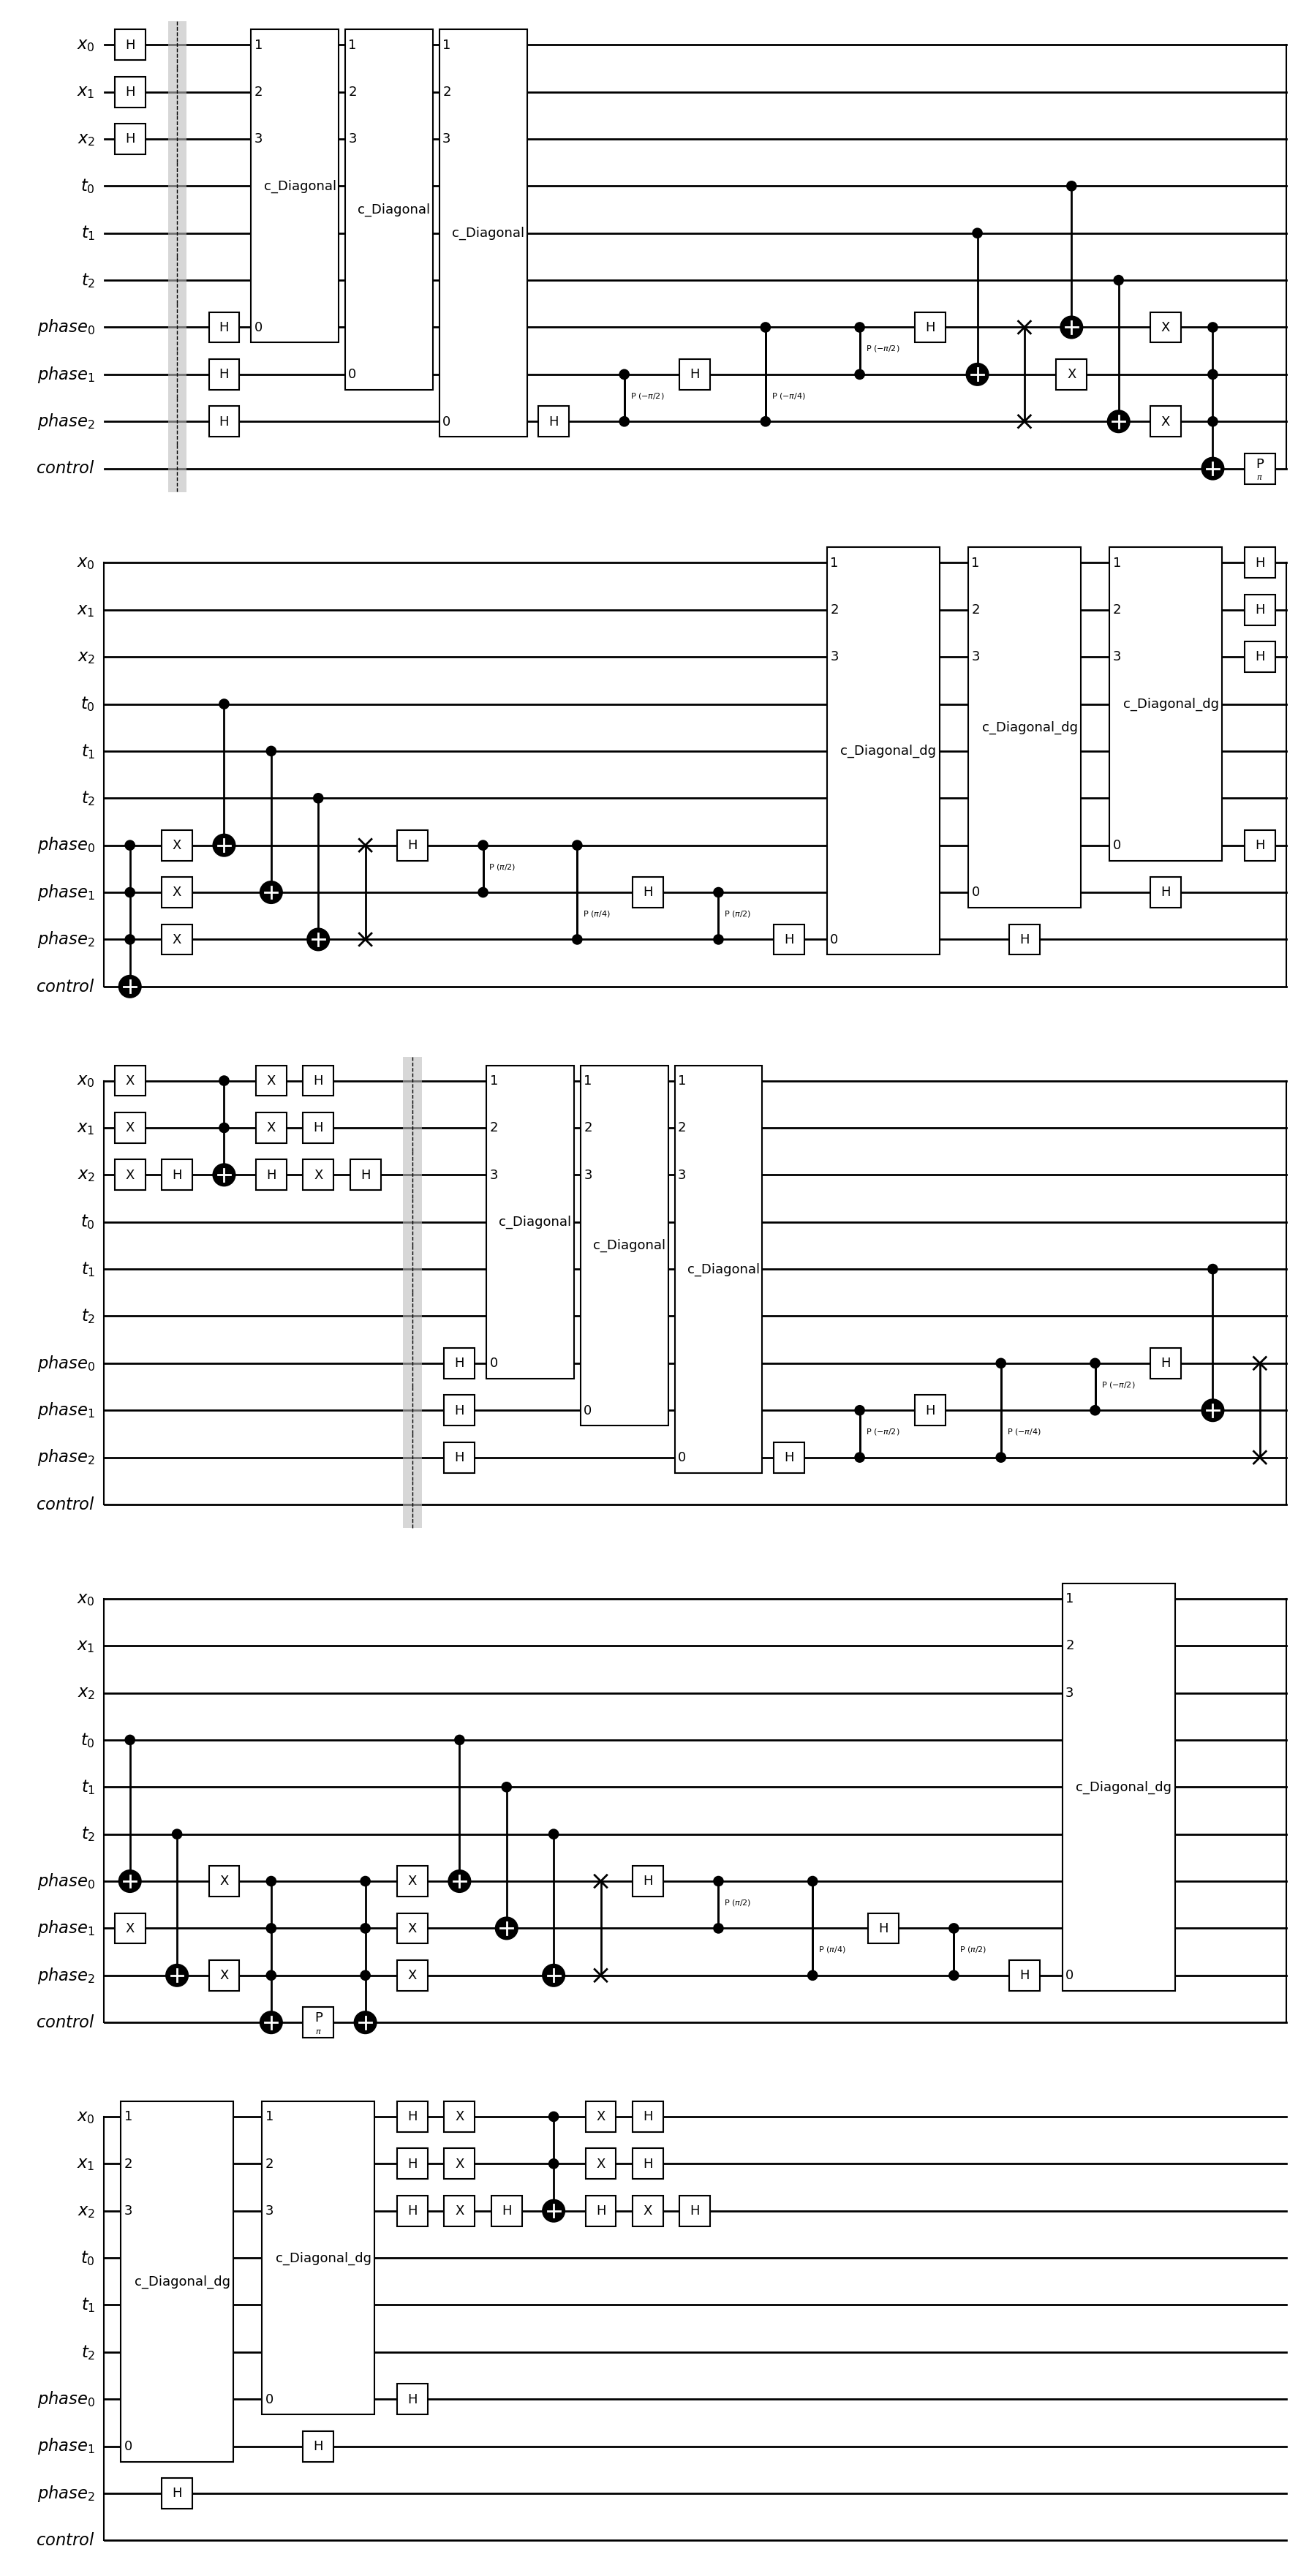

In [61]:
diag_entries=[np.exp(2j * np.pi * num / (2**d)) for num in random_array]
Grover=grover(d,n,diag_entries)
Grover.draw(output="mpl", style="bw")

Now, we create a tester cell. This has an input a number in $\{0,1,,\dots, 2^{d}-1\}$. Then, it compares the the index that number occupies in the random array defined earlier, with the output of the circuit Grover. 

In [148]:
m=6
n=3
d=3

print(random_array)
#prepare initial state
#sv_x=Statevector.from_int(0,2**n)
#sv_t=Statevector.from_int(0,2**d)
#sv_phase=Statevector.from_int(0,2**n)
#sv_control=Statevector.from_int(0,2)
#sv_init=sv_x^sv_t^sv_phase^sv_control
#input in binary
bitstring='0' * (d + 1) + f'{m:0{d}b}' + '0' * n
sv_init=Statevector.from_label(bitstring)
#Evolve state with grover circuit. 

sv_final=sv_init.evolve(Grover)

#Output most probable index. 
probs = sv_final.probabilities_dict()

most_probable_state, max_prob = max(probs.items(), key=lambda item: item[1])

print(f"Most probable state: {most_probable_state}")
print(f"Probability: {max_prob:.6f}")

[1 4 2 3 6 0 7 5]
Most probable state: 0000110100
Probability: 0.945312


As we can see, we used $m=6$. the most probable state is $0000110100$. Look at the rightmost entries. This contains $n$, and encodes $100=4$. Look at the array, and we can see that $6$ is in position $4$ in the array. Hence the code works :)